In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import optbinning as opt
%matplotlib inline
import pandas as pd
from sklearn.impute import SimpleImputer
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from sklearn.preprocessing import OneHotEncoder, StandardScaler,KBinsDiscretizer, LabelEncoder
from sklearn.impute import SimpleImputer
from scipy.stats import mannwhitneyu ,chi2_contingency, anderson, f_oneway
import statsmodels.api as sm 
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
import warnings
warnings.filterwarnings("ignore")

(CVXPY) Apr 15 11:07:24 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Apr 15 11:07:24 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')


In [2]:
data=pd.read_csv("../data/application_train_vf.csv",parse_dates=["date_mensuelle"], index_col=0)

In [3]:
credit_bureau_data=pd.read_csv("../data/cb_findings.csv", index_col=0)
data=data.merge(credit_bureau_data, left_on="SK_ID_CURR", right_on="CB_SK_ID_CURR")

In [4]:
data["date_annee"]=data["date_mensuelle"].dt.year

In [5]:
data_reference = data[data["date_annee"] < 2020]

In [6]:
data_backtest = data[data["date_annee"] == 2020]

In [7]:
import sys
import os
sys.path.append(os.getcwd()+"/..")

In [8]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import openpyxl
path=os.getcwd()
sys.path.append(path+"")
from src.preprocessing import DecisionTreeDiscretizer
from src.score import grid_score, attribute_score, attribute_chr, subplot_segment_default_rate

required_columns={
    "Cash loans" : ["OCCUPATION_TYPE", "NAME_EDUCATION_TYPE" , "CB_NB_CREDIT_CLOSED",
              "CB_DAYS_CREDIT", "AMT_CREDIT","CB_AMT_CREDIT_SUM","AMT_INCOME_TOTAL",
              "AMT_GOODS_PRICE","DAYS_BIRTH", "DAYS_EMPLOYED", "DAYS_REGISTRATION" ],
    "Revolving loans" : ["OCCUPATION_TYPE", "NAME_EDUCATION_TYPE" , "CB_NB_CREDIT_CLOSED",
              "CB_DAYS_CREDIT", "AMT_CREDIT","CB_AMT_CREDIT_SUM","AMT_INCOME_TOTAL",
              "AMT_GOODS_PRICE","DAYS_BIRTH", "DAYS_EMPLOYED", "DAYS_REGISTRATION" ]
}

cash_grid_score=pd.read_excel("../data/grille_de_score_cash.xlsx", index_col=0)
revolving_grid_score = pd.read_excel("../data/grille_de_score_revolving.xlsx", index_col=0)

discretizers={}

with open("../web_app/utils/Revolving/discretizers.pkl", "rb") as f:
    discretizers["Revolving loans"]=pickle.load(f)

with open("../web_app/utils/Cash/discretizers.pkl", "rb") as f:
    discretizers["Cash loans"]=pickle.load(f)

breaks = {}

with open("../web_app/utils/Cash/breaks.pkl", "rb") as f:
    breaks["Cash loans"]=pickle.load(f)

with open("../web_app/utils/Revolving/breaks.pkl", "rb") as f:
    breaks["Revolving loans"]=pickle.load(f)



In [9]:
class Dataset :
    
    def __init__(self,data, contract_type):
        self.contract_type = contract_type
        self.data = data[data["NAME_CONTRACT_TYPE"]==contract_type]
        self.discretizers = discretizers[self.contract_type]
        self.required_columns = required_columns[self.contract_type]
        self.note_breaks = breaks[self.contract_type]
        self.cash_scorecard = cash_grid_score   
        self.revolving_scorecard = revolving_grid_score
        
    group_education_type={
    "Graduated" : ["Academic degree", "Higher education"],
    "Non graduated":["Lower secondary", "Secondary / secondary special", "Incomplete higher"]
}
    group_occupation_type = {
        "Cash loans":{
    0: ['Accountants', 'HR staff', 'High skill tech staff'],
 1: ['Managers', 'Core staff', 'Private service staff', 'Unknown',
        'Medicine staff', 'IT staff', 'Secretaries'],
 2: ['Realty agents', 'Cleaning staff', 'Sales staff', 'Laborers',
        'Cooking staff', 'Security staff'],
 3: ['Drivers', 'Waiters/barmen staff', 'Low-skill Laborers'],
},
        "Revolving loans" : {
       0: ['IT staff', 'Accountants', 'HR staff', 'Managers', 'High skill tech staff', 'Core staff'], 
       1: ['Unknown', 'Medicine staff', 'Private service staff'],
       2: ['Realty agents', 'Secretaries', 'Laborers', 'Security staff',
              'Sales staff', 'Drivers', 'Waiters/barmen staff', 'Cleaning staff',
              'Cooking staff', 'Low-skill Laborers']
}
    }
    
    amt_goods_price_med ={
        "Cash loans" : 454500.0,
        "Revolving loans" : 270000.0
    }
    
    def check_columns(self):
        if len(set(self.required_columns).difference(self.data.columns)) == 0:
            return True
        else :
            return False
        
    def _features_tranformation(self):
        self.data["NAME_EDUCATION_TYPE"] = self.data["NAME_EDUCATION_TYPE"].map({value: key for key, values in self.group_education_type.items() for value in values})
        self.data["OCCUPATION_TYPE"].fillna("Unknown", inplace=True)
        self.data["OCCUPATION_TYPE"] = self.data["OCCUPATION_TYPE"].map({value: key for key, values in self.group_occupation_type[self.contract_type].items() for value in values})
        
        if self.contract_type == "Cash loans":
            # ['BORROWER_AGE', 'BORROWER_SENIORITY', 'AMT_CREDIT_NORM', 'CB_NB_CREDIT_CLOSED', 'CB_DAYS_CREDIT']
            
            self.data['BORROWER_AGE']=self.discretizers['BORROWER_AGE'].transform(self.data['BORROWER_AGE'])
            self.data['BORROWER_SENIORITY']=self.discretizers['BORROWER_SENIORITY'].transform(self.data['BORROWER_SENIORITY'])
            self.data['AMT_CREDIT_NORM']=self.discretizers['AMT_CREDIT_NORM'].transform(self.data['AMT_CREDIT_NORM'])
            self.data['CB_NB_CREDIT_CLOSED']=self.discretizers['CB_NB_CREDIT_CLOSED'].transform(self.data['CB_NB_CREDIT_CLOSED'])
            self.data['CB_DAYS_CREDIT']=self.discretizers['CB_DAYS_CREDIT'].transform(self.data['CB_DAYS_CREDIT'])
            pass
        
        elif self.contract_type == "Revolving loans":
            # self.data['BORROWER_AGE']=self.discretizers['BORROWER_AGE'].transform(self.data['BORROWER_AGE'])
            self.data['BORROWER_SENIORITY']=self.discretizers['BORROWER_SENIORITY'].transform(self.data['BORROWER_SENIORITY'])
            # self.data['AMT_CREDIT_NORM']=self.discretizers['AMT_CREDIT_NORM'].transform(self.data['AMT_CREDIT_NORM'])
            self.data['CB_NB_CREDIT_CLOSED']=self.discretizers['CB_NB_CREDIT_CLOSED'].transform(self.data['CB_NB_CREDIT_CLOSED'])
            self.data['CB_DAYS_CREDIT']=self.discretizers['CB_DAYS_CREDIT'].transform(self.data['CB_DAYS_CREDIT'])
            self.data["AMT_GOODS_PRICE"] = self.discretizers['AMT_GOODS_PRICE'].transform(self.data['AMT_GOODS_PRICE'])
            self.data["DAYS_LAST_PHONE_CHANGE"] = self.discretizers['DAYS_LAST_PHONE_CHANGE'].transform(self.data['DAYS_LAST_PHONE_CHANGE'])
            pass
        
    def transform_columns(self):
        
        if self.check_columns():

            self.data["AMT_CREDIT_TO_INCOME"]=(self.data["AMT_CREDIT"] + self.data["CB_AMT_CREDIT_SUM"])/self.data["AMT_INCOME_TOTAL"]
            self.data["AMT_GOODS_PRICE"]=self.data["AMT_GOODS_PRICE"].fillna(self.amt_goods_price_med[self.contract_type])
            
            self.data["AMT_CREDIT_NORM"]=self.data["AMT_CREDIT"]/self.data["AMT_GOODS_PRICE"]
            # self.data["AMT_ANNUITY"]=(self.data["AMT_ANNUITY"]+self.data["CB_AMT_ANNUITY"])/self.data["AMT_INCOME_TOTAL"]
            self.data["AMT_INCOME_TOTAL_NORM"]=self.data["AMT_INCOME_TOTAL"]/self.data["AMT_GOODS_PRICE"]
            self.data["BORROWER_AGE"]=self.data["DAYS_BIRTH"].apply(np.abs)//365
            self.data["BORROWER_SENIORITY"]=self.data["DAYS_EMPLOYED"].apply(np.abs)//365
            self.data["BORROWER_FIDELITY"]=self.data["DAYS_REGISTRATION"].apply(np.abs)//365
            self._features_tranformation()
            
        else:
            pass
        
    def score(self):
        if self.contract_type == "Cash loans":
            attribute_score(grid_score=self.cash_scorecard, data=self.data)
            pass
        elif self.contract_type == "Revolving loans":
            attribute_score(grid_score=self.revolving_scorecard, data=self.data)
            pass
        
    def get_chr(self):
        self.score()
        self.data["Segment"] = pd.cut(self.data["Note"], bins=self.note_breaks, labels=[i for i in range(len(self.note_breaks)-1)] )
        pass

In [10]:
data_backtest_cash = data_backtest[data_backtest["NAME_CONTRACT_TYPE"]=="Cash loans"]
data_backtest_revolving = data_backtest[data_backtest["NAME_CONTRACT_TYPE"]=="Revolving loans"]

In [11]:
data_backtest_cash.shape , data_backtest_revolving.shape

((34663, 132), (3701, 132))

#### Population Scoring

In [12]:
dataset_backtest_cash = Dataset(data_backtest, "Cash loans")

In [13]:
dataset_backtest_cash.transform_columns()
dataset_backtest_cash.get_chr()

In [14]:
dataset_backtest_cash.data["Segment"]

267744    3
267745    2
267746    3
267747    5
267748    3
         ..
306102    5
306103    3
306104    1
306105    2
306106    0
Name: Segment, Length: 34663, dtype: category
Categories (7, int64): [0 < 1 < 2 < 3 < 4 < 5 < 6]

In [15]:
dataset_reference_cash = Dataset(data_reference, "Cash loans")
dataset_reference_cash.transform_columns()
dataset_reference_cash.get_chr()

In [16]:
def calculate_contribution_to_is(x):
    return (x["proportion_reference"] - x["proportion_backtest"])*np.log(x["proportion_reference"] / x["proportion_backtest"])

#### System Stability Index

In [17]:
# SSI 
def system_stability_index(reference,backtest, variable):
    dist_ref = reference[variable].value_counts(normalize=True).reset_index()
    dist_back = backtest[variable].value_counts(normalize=True).reset_index()
    dist_all = dist_ref.merge(dist_back, how="outer", on=variable, suffixes=("_reference","_backtest"))
    dist_all["contribution"]=dist_all.apply(calculate_contribution_to_is, axis=1)
    return dist_all, dist_all["contribution"].sum()

In [18]:
system_stability_index(dataset_reference_cash.data,dataset_backtest_cash.data, "Segment")

(  Segment  proportion_reference  proportion_backtest  contribution
 0       0              0.063920             0.063874  3.260648e-08
 1       1              0.148708             0.151030  3.596648e-05
 2       2              0.202028             0.205787  6.929938e-05
 3       3              0.227755             0.227771  1.065762e-09
 4       4              0.199647             0.199411  2.772960e-07
 5       5              0.127905             0.123449  1.580070e-04
 6       6              0.030036             0.028677  6.296260e-05,
 0.00032654644743646216)

In [19]:
from src.score import subplot_segment_default_rate

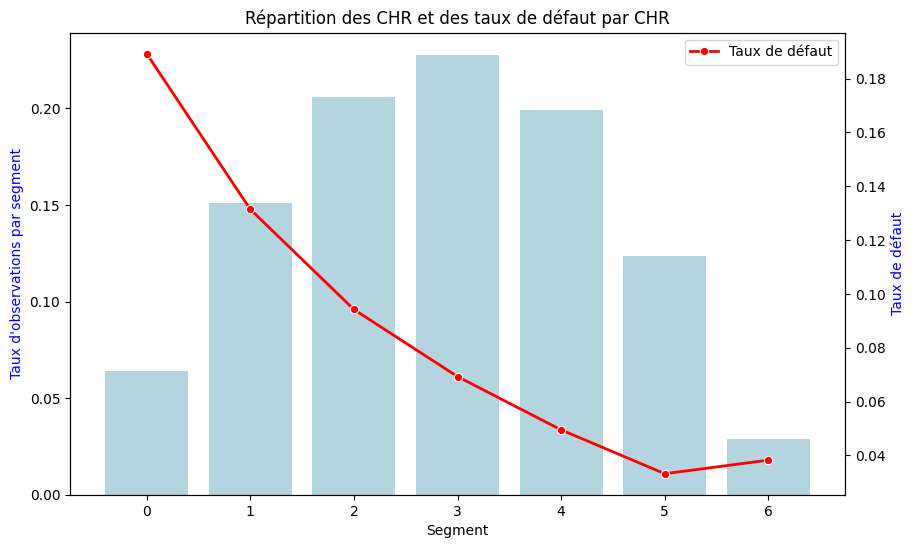

In [20]:
subplot_segment_default_rate(dataset_backtest_cash.data)

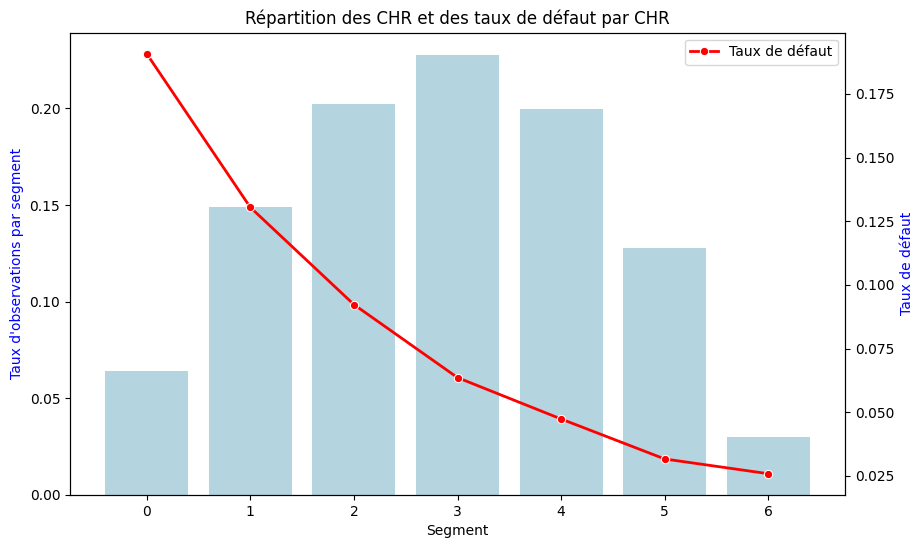

In [21]:
subplot_segment_default_rate(dataset_reference_cash.data)

In [22]:
from scipy.stats import ks_2samp

In [23]:
ks_2samp(data1=dataset_reference_cash.data["Note"], data2=dataset_backtest_cash.data["Note"], alternative="two-sided")

KstestResult(statistic=0.008389234966011516, pvalue=0.02785213975219314, statistic_location=630, statistic_sign=-1)

In [24]:
# # KS test
# def kolmogorov_smirnov_test(reference, backtest,colname):
#     results = ks_2samp(data1=reference[colname], data2=backtest[colname])
#     if results[1] < 0.05:
#         print(f"Null hypothesis is rejected : The distributions of {colname} are not the same")
#     else :
#         print(f"Null hypothesis is not rejected : The distributions of {colname} are the same")

#### Stabilité des variables explicatives


In [25]:
cash_features = ["OCCUPATION_TYPE", "NAME_EDUCATION_TYPE"  , "AMT_CREDIT_NORM" , "BORROWER_AGE" , "BORROWER_SENIORITY" , "CB_NB_CREDIT_CLOSED", "CB_DAYS_CREDIT"]


In [26]:
for variable  in cash_features:
    print(f"{variable} stability : ")
    print(system_stability_index(dataset_reference_cash.data,dataset_backtest_cash.data, variable))
    print(60*"**")

OCCUPATION_TYPE stability : 
(   OCCUPATION_TYPE  proportion_reference  proportion_backtest  contribution
0                0              0.068773             0.067969      0.000009
1                1              0.516917             0.514785      0.000009
2                2              0.341374             0.343998      0.000020
3                3              0.072937             0.073248      0.000001, 3.967468274184672e-05)
************************************************************************************************************************
NAME_EDUCATION_TYPE stability : 
(  NAME_EDUCATION_TYPE  proportion_reference  proportion_backtest  contribution
0           Graduated              0.235738             0.235063  1.936147e-06
1       Non graduated              0.764262             0.764937  5.960906e-07, 2.532237213216641e-06)
************************************************************************************************************************
AMT_CREDIT_NORM stability : 


In [27]:
##### revolving
dataset_reference_revolving = Dataset(data_reference, "Revolving loans")
dataset_reference_revolving.transform_columns()
dataset_reference_revolving.get_chr()

In [28]:
dataset_backtest_revolving = Dataset(data_backtest, "Revolving loans")
dataset_backtest_revolving.transform_columns()
dataset_backtest_revolving.get_chr()

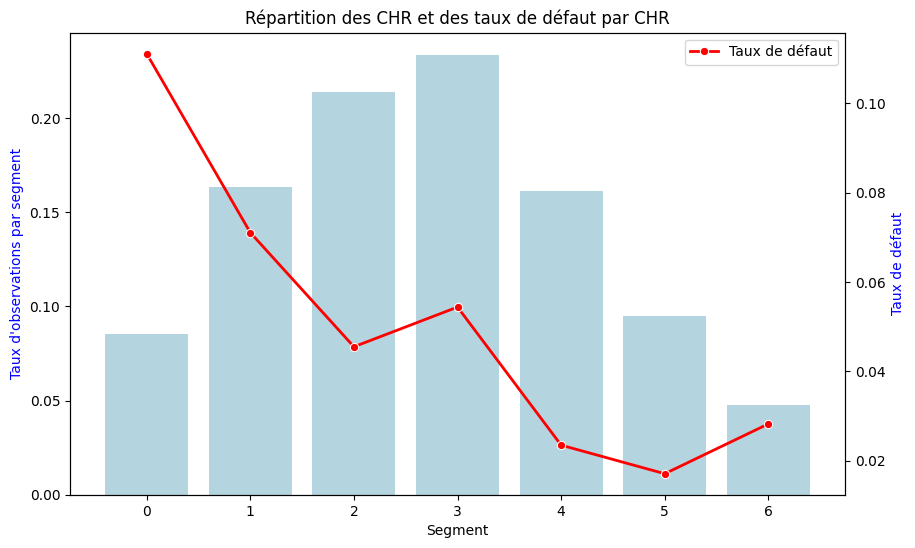

In [29]:
subplot_segment_default_rate(dataset_backtest_revolving.data)

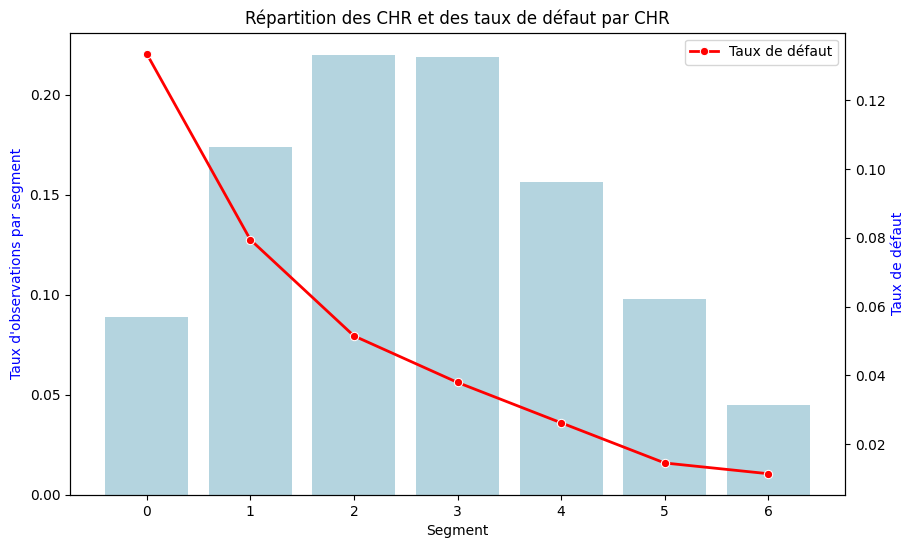

In [30]:
subplot_segment_default_rate(dataset_reference_revolving.data)

In [31]:
ks_2samp(data1=dataset_reference_revolving.data["Note"], data2=dataset_backtest_revolving.data["Note"], alternative="two-sided")

KstestResult(statistic=0.02058568568296043, pvalue=0.12754181373340978, statistic_location=427, statistic_sign=1)

In [32]:
system_stability_index(dataset_reference_revolving.data,dataset_backtest_revolving.data, "Segment")

(  Segment  proportion_reference  proportion_backtest  contribution
 0       0              0.088841             0.085158      0.000156
 1       1              0.173556             0.163558      0.000593
 2       2              0.219921             0.213842      0.000170
 3       3              0.218703             0.233577      0.000979
 4       4              0.156189             0.161125      0.000154
 5       5              0.097760             0.094891      0.000086
 6       6              0.045029             0.047851      0.000171,
 0.0023087116304621267)

In [33]:
dataset_backtest_revolving.data["AMT_GOODS_PRICE"].isna().mean()

0.0

In [34]:
revolving_features = ["AMT_GOODS_PRICE", "OCCUPATION_TYPE", "NAME_EDUCATION_TYPE" , "DAYS_LAST_PHONE_CHANGE" , "BORROWER_SENIORITY" , "CB_NB_CREDIT_CLOSED", "CB_DAYS_CREDIT"]

for variable  in revolving_features:
    print(f"{variable} stability : ")
    print(system_stability_index(dataset_reference_revolving.data,dataset_backtest_revolving.data, variable))
    print(60*"**")

AMT_GOODS_PRICE stability : 
(        AMT_GOODS_PRICE  proportion_reference  proportion_backtest  contribution
0      (-inf, 168750.0]              0.100723             0.093488  5.391988e-04
1  (168750.0, 191250.0]              0.216563             0.205620  5.674290e-04
2  (191250.0, 517500.0]              0.547711             0.565793  5.873359e-04
3       (517500.0, inf]              0.135004             0.135099  6.695025e-08, 0.0016940306691512897)
************************************************************************************************************************
OCCUPATION_TYPE stability : 
(   OCCUPATION_TYPE  proportion_reference  proportion_backtest  contribution
0                0              0.294550             0.289111      0.000101
1                1              0.295531             0.305323      0.000319
2                2              0.409919             0.405566      0.000046, 0.000466986914584121)
***************************************************************

#### Tests d'adéquation de la PD

##### Test binomial

In [35]:
from scipy.stats import binom_test

def binomial_test(df, summary):
    # Calcul des défauts attendus
    df2 = pd.DataFrame()
    df2["Expected"] = summary["PD"]
    # Nombre total de défauts observés
    df2["Observed"] = df[["Segment","TARGET"]].groupby("Segment")["TARGET"].sum()
    df2["Total obs"] = df[["Segment","TARGET"]].groupby("Segment").count()
    # Nombre total de cas
    def binom_test2(x):
        return binom_test(x["Observed"], x["Total obs"], x["Expected"])
    # Effectuer le test binomial
    p_value = df2.apply(binom_test2, axis=1)
    
    return p_value, df2["Total obs"], df2["Observed"]


In [36]:
with open("../utils/Cash/pd_summary_table.pkl", "rb") as f:
    summary_cash = pickle.load(f)

In [37]:
summary_cash["Nb obs"], summary_cash["Observed Defaults"],summary_cash["Binomial test (p-value)"] = binomial_test(dataset_backtest_cash.data, summary_cash)[1], binomial_test(dataset_backtest_cash.data, summary_cash)[2], binomial_test(dataset_backtest_cash.data, summary_cash)[0]

In [38]:
summary_cash

,Segment,LRA,MOC_A,MOC_C,PD,Nb obs,Observed Defaults,Binomial test (p-value)
0,0,0.190468,0.003063,0.007310,0.200842,2214,419,0.176209
1,1,0.131752,0.001502,0.004198,0.137451,5235,688,0.213337
2,2,0.091733,0.001193,0.003043,0.095969,7133,672,0.629538
3,3,0.062877,0.000923,0.002378,0.066178,7895,547,0.267304
4,4,0.046966,0.000880,0.002266,0.050113,6912,342,0.846966
5,5,0.031889,0.000802,0.002303,0.034994,4279,142,0.560187
6,6,0.026482,0.001591,0.004334,0.032407,994,38,0.282544


In [39]:
# revolving 
with open("../utils/Revolving/pd_summary_table.pkl", "rb") as f:
    summary_revolving = pickle.load(f)

In [40]:
summary_revolving["Nb obs"], summary_revolving["Observed Defaults"],summary_revolving["Binomial test (p-value)"] = binomial_test(dataset_backtest_revolving.data, summary_revolving)[1], binomial_test(dataset_backtest_revolving.data, summary_revolving)[2], binomial_test(dataset_backtest_revolving.data, summary_revolving)[0]

In [41]:
summary_revolving

,Segment,LRA,MOC_A,MOC_C,PD,Nb obs,Observed Defaults,Binomial test (p-value)
0,0,0.137796,0.006229,0.016712,0.160738,315,35,0.017085
1,1,0.079234,0.004103,0.009464,0.092801,605,43,0.068232
2,2,0.050962,0.002460,0.007324,0.060746,791,36,0.073928
3,3,0.037172,0.002279,0.006185,0.045636,864,47,0.220638
4,4,0.025781,0.002801,0.006111,0.034693,596,14,0.145804
5,5,0.016404,0.001530,0.004684,0.022618,351,6,0.592457
6,6,0.009841,0.001391,0.008398,0.019630,177,5,0.404737


##### Test de Hosmer Lemeshow

In [42]:
# from scipy.stats import chisquare

In [43]:
35/315

0.1111111111111111

In [44]:
# def hosmer_lemeshow_test(df, predicted_prob, observed, groups=10):
#     df['decile'] = pd.qcut(df[predicted_prob], q=groups, duplicates='drop')
#     result = df.groupby('decile').agg(
#         observed_sum=pd.NamedAgg(column=observed, aggfunc='sum'),
#         expected_sum=pd.NamedAgg(column=predicted_prob, aggfunc='mean')
#     )
#     result['expected_freq'] = result['expected_sum'] * len(df) / groups
#     chi_square_stat, p_value = chisquare(result['observed_sum'], f_exp=result['expected_freq'])
    
#     return chi_square_stat, p_value

# # Utilisation du test de Hosmer-Lemeshow
# hl_stat, p_value_hl = hosmer_lemeshow_test(summary, 'PD', 'TARGET')
# print(f'Hosmer-Lemeshow chi-square: {hl_stat}, p-value: {p_value_hl}')

In [45]:
# def hosmer_lemeshow_test(summary) :
#     return chisquare(summary["Observed DR"], summary["PD"])

In [46]:
# hosmer_lemeshow_test(summary_cash)